# Data Wizard Take Home Exercise - Assignment Part 1
Author: Giacomo Dalla Chiara

The objective of this exercise is to estimate the average hourly pay and visualize it using a heatmap, taking into account errors, outliers, edge cases, lack of data, extreme events, and robustness of the estimated averages.
I first generate a synthetic dataset of drivers' trips to work on. I then propose four different models, ordered by level of complexity, to approach the estimation probem: 
- V0: non-parametrics model using the mean function,
- V1: non-parametric model using the median function,
- V2: parametrics model using linear regression,
- V3: parametric model using mixed effect regression.

In [123]:
rm(list=ls()) #clean the console
library(ggplot2) #package used for plotting
library(repr) #package used to control plot size in notebook
#install.packages("lme4", repos='http://cran.us.r-project.org')
#library(lme4) #package for estimating mixed-effect models

### Synthetic data generation

In this first step, I generate a synthetic dataset of 1000 trips performed by 50 drivers. Each observation is a trip, characterized by the following variables:
- driver_id: assuming we have 50 unique driver IDs
- time_of_day: assuming we have data from midnight (0) to 11 pm (23)
- pick_up_date: we assume data is from a week in February 2023
- earnings_pay: assuming earnings are exponentially distributed with rate=1 (parameter of the exp distirbution)
- day_of_week: Monday, Tuesday, ...
- special_event: =1 whenever a trip is considered belonging to a "special event", e.g. a sport event

By generating synthetic data we can test how different models behave under certain conditions (e.g. outliers, extreme values). Synthetic data can also be used for simulation (e.g. we could simulate a entire population of drivers, or simulate drivers in a location for which we have little data).

In [124]:
# Fix a seed number for random data generation to ensure replication
set.seed(61)

# Fix the total size of the sample to generate
n <- 1000

# Generate synthetic job dataset
job <- data.frame("driver_id"=sample(1:50, n, replace=TRUE),
                  "time_of_day"=sample(0:23, n, replace=TRUE), 
                  "pick_up_date"=sample(seq(as.Date("2023/02/13"), as.Date("2023/02/19"), by="day"), n, replace=T),
                  "earnings_pay"=rexp(n, rate = 0.045)) 

# Adding day of the week
job$day_of_week <- weekdays(job$pick_up_date) 

# Adding special events (e.g. super bowl)
job$special_event <- 0
job[c(1,50,467,835,456,23,788),"special_event"] <- 1
job[c(1,50,467,835,456,23,788),"earnings_pay"] <- job[c(1,50,467,835,456,23,788),"earnings_pay"]+400 #I'm adding $400 to earnings obtained during special events
job$special_event <- as.factor(job$special_event)

str(job)

'data.frame':	1000 obs. of  6 variables:
 $ driver_id    : int  12 7 23 42 42 41 20 34 11 33 ...
 $ time_of_day  : int  9 8 14 4 6 17 0 17 20 1 ...
 $ pick_up_date : Date, format: "2023-02-17" "2023-02-14" ...
 $ earnings_pay : num  426.48 14.69 3.45 2.25 38.04 ...
 $ day_of_week  : chr  "Friday" "Tuesday" "Monday" "Sunday" ...
 $ special_event: Factor w/ 2 levels "0","1": 2 1 1 1 1 1 1 1 1 1 ...


### V0. Non-parametric model: Mean

In the first model V0, I eastimate average hourly pay using the mean function

In [125]:
# Use the aggregate() function to compute the mean pay for each combination of day and time
avg_pay <- aggregate(job$earnings_pay, list(job$time_of_day, job$day_of_week), FUN=mean)
names(avg_pay) <- c("time_of_day", "day_of_week", "value_mean")

Then, I use ggplot to create a heatmap of the mean hourly pay

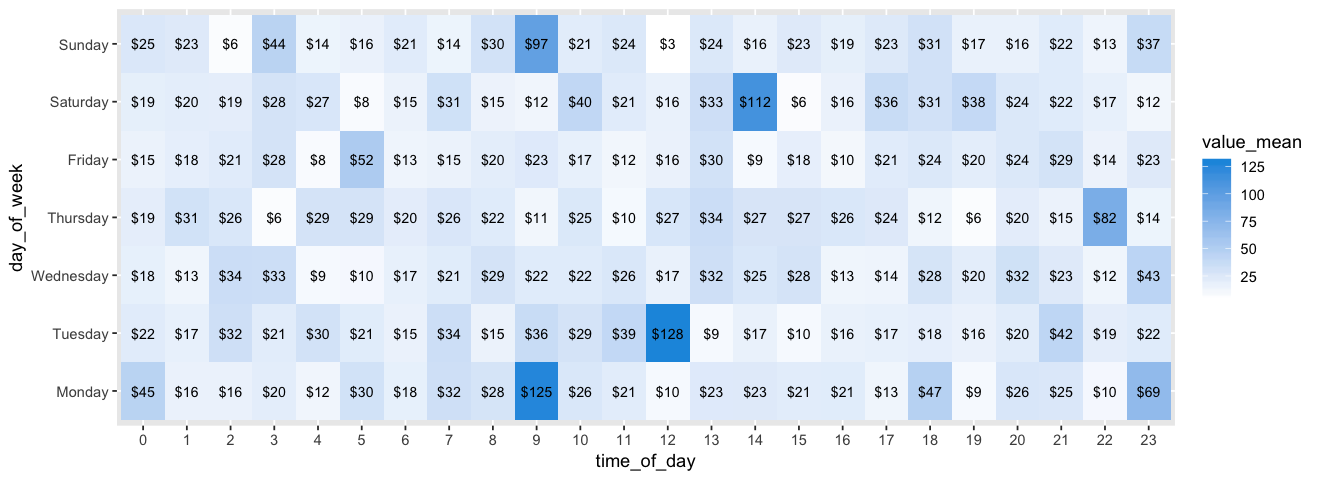

In [126]:
avg_pay$lab_mean <- paste0("$",as.character(floor(avg_pay$value_mean)))
avg_pay$time_of_day <- as.factor(avg_pay$time_of_day)
avg_pay$day_of_week <- as.factor(avg_pay$day_of_week)
levels(avg_pay$day_of_week) <- c("Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday")
hm_mean <- ggplot(avg_pay, aes(time_of_day, day_of_week)) +
      geom_tile(aes(fill = value_mean)) +
      geom_text(aes(label = lab_mean), size=3) +
      scale_fill_gradient(low = "white", high = "#1b98e0")
options(repr.plot.width=11, repr.plot.height=4)
hm_mean

Note that the mean function is not robust to extreme values and outliers. Cells representing average hourly pay for Monday, 9 am, Tuesday, 12 pm, and Saturday, 2 pm, show skewed averages due to special event observations.

### V1. Non-parametric model: Median

In the second model V1, I use the median funciton to estimate average hourly pay. The median function is more rovust to extreme values and outliers than the mean function.

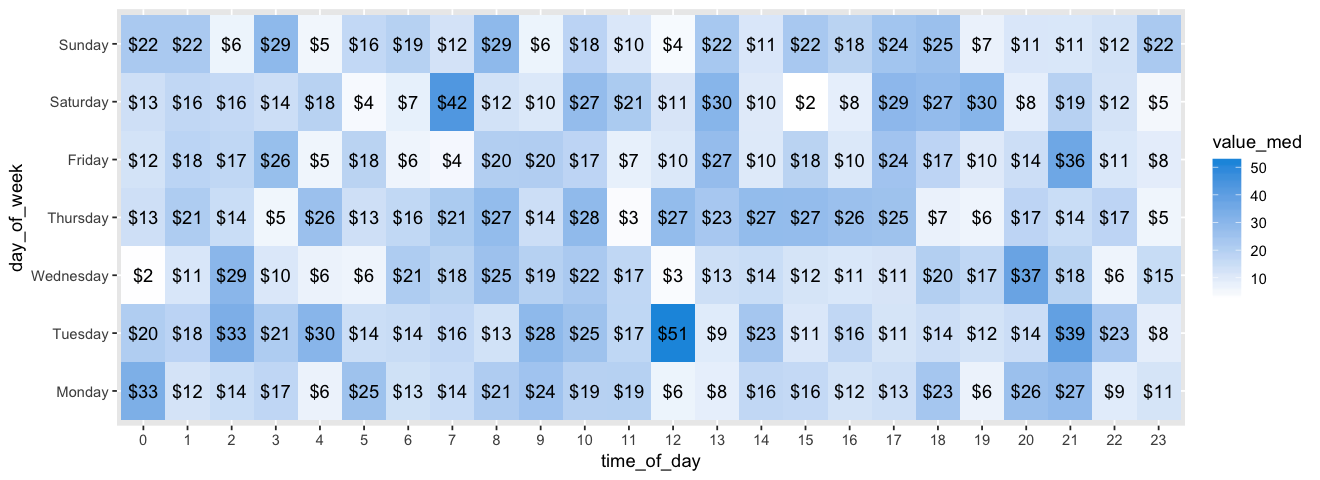

In [127]:
# Add column to the avg_pay dataset reporting the median hourly pay
avg_pay$value_med <- aggregate(job$earnings_pay, list(job$time_of_day, job$day_of_week), FUN=median)$x

# Same as above, I use ggplot to plot a heatmap of avrage hourly earnings 
avg_pay$lab_med <- paste0("$",as.character(floor(avg_pay$value_med)))
avg_pay$time_of_day <- as.factor(avg_pay$time_of_day)
hm_med <- ggplot(avg_pay, aes(time_of_day, day_of_week)) +
  geom_tile(aes(fill = value_med)) +
  geom_text(aes(label = lab_med)) +
  scale_fill_gradient(low = "white", high = "#1b98e0")
options(repr.plot.width=11, repr.plot.height=4)
hm_med

Note that, in comparison with the heatmap generated by V0, the large average hourly pays for Monday 9 am and Saturday 2 pm disappear. Now the Tuesday 12 pm and Saturday 7 am show the highest averages.

### Lack of data and confidence of the estimates

While the median function take care of extreme values and outliers, lack of observations for certain combination of days and times might still be a problem. In the plots above I only reported the point estimates for the average hourly pay, but I do not show how confident I am that these point estimates are as close as possible to the "true" average hourly pay. To tackle this problem, I would us:
1) a rule base method, i.e. I would identify how often and when/where we have less than, for instance, 5 observations
2) compute 95% confidence interval for the estimate

The narrower the confidence interval around the point estimate, the more precise the estimate is. Lack of data would then be reflected by a wider confidence interval. Confidence intervals could be added somehow to the visualization to aid decision making. Or it could be used in the background, for instance to identify point estimates where the CI is too wide.

In the following code I compute first the sample size that contributes to each point estimates, then the confidence interval for just one point estimate as an example.

In [128]:
# Add column to avg_pay containing sample size
avg_pay$sample_size <- aggregate(job$earnings_pay, list(job$time_of_day, job$day_of_week), FUN=length)$x

# Display the point estimates with small sample size using a rule-based method
avg_pay[avg_pay$sample_size<5,]

# Compute confidence interval for the median hourly pay for Tuesday 11 am
wilcox.test(job[job$time_of_day==12 & job$day_of_week=="Tuesday","earnings_pay"], alternative="two.sided", correct=TRUE, conf.int=TRUE, conf.level=0.95)$conf.int

,time_of_day,day_of_week,value_mean,lab_mean,value_med,lab_med,sample_size
5,4,Monday,12.833006,$12,6.735966,$6,3
18,17,Monday,13.024267,$13,13.961362,$13,4
21,20,Monday,26.851343,$26,26.051626,$26,3
22,21,Monday,25.687073,$25,27.851747,$27,4
25,0,Tuesday,22.204722,$22,20.944869,$20,4
28,3,Tuesday,21.411347,$21,21.432330,$21,4
29,4,Tuesday,30.203213,$30,30.203213,$30,2
33,8,Tuesday,15.772899,$15,13.048394,$13,3
35,10,Tuesday,29.148743,$29,25.268841,$25,3
37,12,Tuesday,128.671484,$128,51.755472,$51,4


[1]  1.141347 54.826569
attr(,"conf.level")
[1] 0.95

### V2. Parametric model: Linear regression

The above models are non-parametric, i.e. they do not make any assumption on how the true average hourly pay are generated. In model V2 we impose a regression formula for the generation of the average hourly pay. In the regression model below, the average hourly pay is the dependent variable, and it is explained by the following predictors:
- time_of_day
- day_of_week
- special_event

I estimate the regression formula unknown parameters using the sample data (job).

In [129]:
tmp <- job # I define a new temporary dataset tmp
tmp$day_of_week <- as.factor(tmp$day_of_week)
tmp$time_of_day <- as.factor(tmp$time_of_day)

# I estimate the regression parameters using the lm() function
modv2 <- lm(earnings_pay~day_of_week+time_of_day+special_event, data=tmp)
summary(modv2)


Call:
lm(formula = earnings_pay ~ day_of_week + time_of_day + special_event, 
    data = tmp)

Residuals:
    Min      1Q  Median      3Q     Max 
-33.092 -15.427  -6.487   8.053 223.497 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)           26.1036     3.8098   6.852  1.3e-11 ***
day_of_weekMonday     -0.6691     2.8216  -0.237   0.8126    
day_of_weekSaturday   -0.9186     2.7321  -0.336   0.7368    
day_of_weekSunday     -2.7977     2.7719  -1.009   0.3131    
day_of_weekThursday   -6.5266     2.6862  -2.430   0.0153 *  
day_of_weekTuesday    -3.2822     2.7862  -1.178   0.2391    
day_of_weekWednesday  -2.8549     2.7771  -1.028   0.3042    
time_of_day1          -4.3327     4.8367  -0.896   0.3706    
time_of_day2           0.7905     4.9214   0.161   0.8724    
time_of_day3           2.4743     5.4777   0.452   0.6516    
time_of_day4          -3.2924     5.1846  -0.635   0.5256    
time_of_day5          -4.5268     4.9798  -0.909   0

Note in the table of estimated parameters above that we have one parameters estimated for 6 days of the week (Friday is used as reference level) and 23 hours of the day (midnight is used as reference level).
Using the estimated regression model, I then predict the average hourly pay for each compbination of inputs. We assume here that special_events==0.

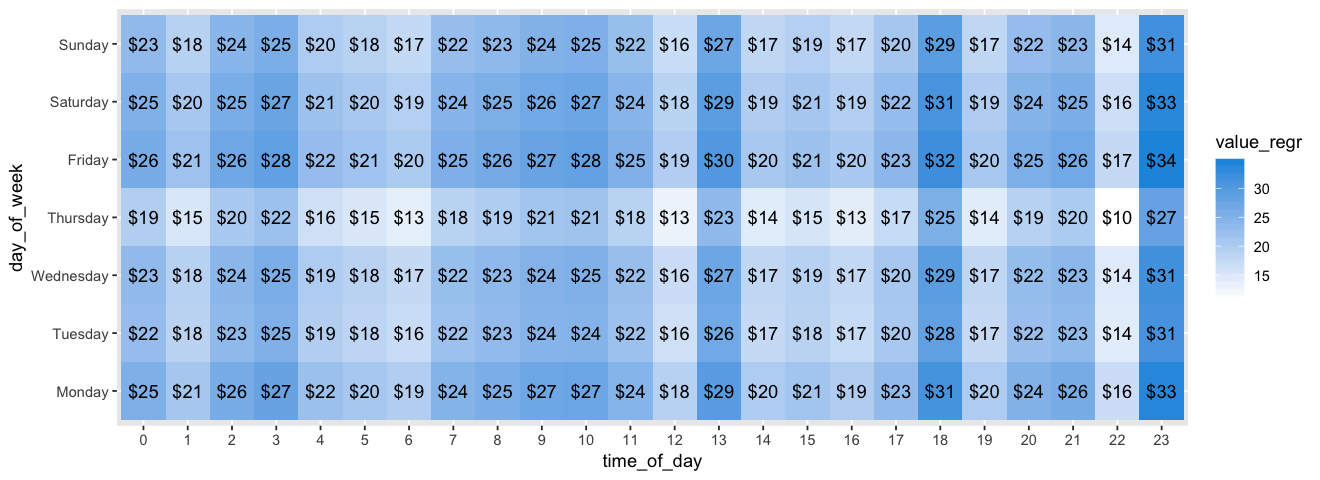

In [130]:
# Add column to avg_pay where special_event==0
avg_pay$special_event <- as.factor(0)

# Predict values using estimated regression model
avg_pay$value_regr <- predict(modv2, avg_pay)

# I use ggplot to visualize the new results
avg_pay$lab_regr <- paste0("$",as.character(floor(avg_pay$value_regr)))
hm_regr <- ggplot(avg_pay, aes(time_of_day, day_of_week)) +
  geom_tile(aes(fill = value_regr)) +
  geom_text(aes(label = lab_regr)) +
  scale_fill_gradient(low = "white", high = "#1b98e0")
options(repr.plot.width=11, repr.plot.height=4)
hm_regr

Note that the new heatmap show values that are much more closer to the overall median for the whole sample than the heatmaps generated with the mean and median functions. This is reasonable as the data was generated using a uniform distribution, and we would not expect strong differences between different times of the day and days of the week.

A parametric model has other advantages:
- it uses the whole dataset to predict average hourly pay
- it allows to use multiple predictors simultanously. For instance, in the model we also use special events. If for some reason we are interested to produce the same visualization only for special events, then we only need to change the special_event column from 0 to 1 and predict the new values
- it allows to use new variables (e.g. we can introduce spacial predictors, or individual-specific characteristics, for instance type of vehicle used, user rating etc.)
- model diagnostic can be used to identify outliers and extreme values (see below). While linear regression is still influenced by outliers, there are more advanced regression methods that can further increase robustness of the model

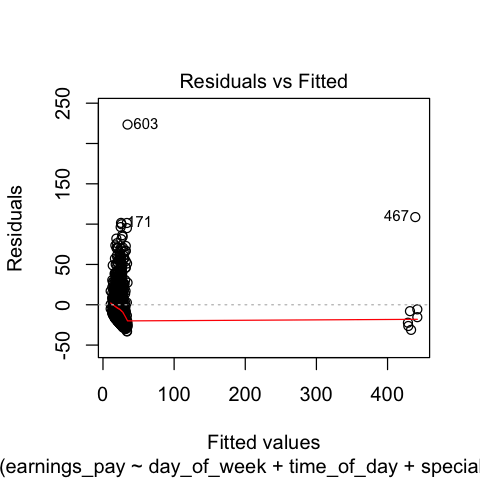

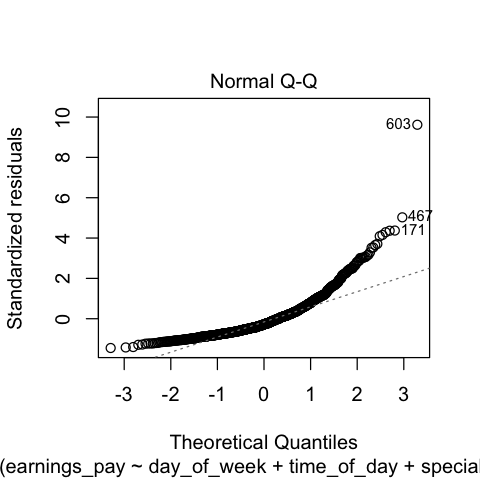

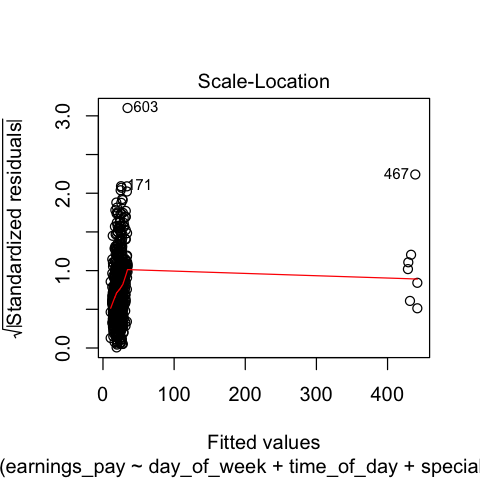

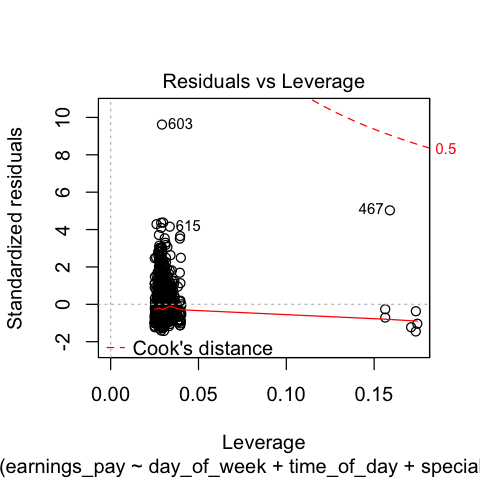

In [131]:
# Run model diagnostic to identify potential outliers and extreme values
options(repr.plot.width=4, repr.plot.height=4)
plot(modv2)

### V3. Parametric model: Mixed effet model

A problem with model V2 is that it assumes that observations are independently generated. This is not the case, since different trips performed by the same driver over time might be correlated. For instance, a driver might have a stronger preference for longer trips, hence his/her earnings will be larger than other drivers. Or a driver might be seen as more friendly by customers, and therefore she/he will be able to earn larger amount of tips.

In this last model V3 I will take this problem into account, and include driver_id as a random factor in the regression model. The obtained regression is a "mixed-effect model".

In [133]:
tmp <- job # I define a new temporary dataset tmp
tmp$day_of_week <- as.factor(tmp$day_of_week)
tmp$time_of_day <- as.factor(tmp$time_of_day)
tmp$driver_id <- as.factor(tmp$driver_id)

# I estimate the regression parameters using the lmer() function
modv3 <- lmer(earnings_pay ~ day_of_week + 
              time_of_day + 
              special_event +
              (1|driver_id), data=tmp)
summary(modv3)

ERROR: Error in lmer(earnings_pay ~ day_of_week + time_of_day + special_event + : could not find function "lmer"


Somehow I was not able to load the lme4 package in jupyter. I will attach also the R file separately, where the results from modv3 are computed. 

### Conclusion

I wanted to show 4 different models, as they approach the problem in different ways and each has some advantages and disadvantages. Moreover, I usually operate by starting from a "baby model" and then progressively test and compare more complex models. 

Here, the median is defiantely more robust than the mean function, in estimating the average hourly pay. However, regression models are more flexible and can make use of multiple variables simultanously, as well as make use of the whole dataset.

Here I tested a few classic statistical models, which are simpler but of easy interpretation. Going forward, more complex machine learning models can be tested, especially given that the goal here is not understanding the relationship between the dependent variable (hourly pay) and the input data, but rather have the best prediction.